# [Exp-13]CV5_추천시스템

###목차
0. Import library
1. Data preprocessing
2. EDA
3. 선호영화 5개
4. CSR matrix 생성
5. als_model 구성 훈련
6. 나의 선호도
7. 비슷한 영화 추천받기
8. 내가 좋아할 영화 추천받기

회고

#0.Import Library

In [1]:
! pip install Cython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! pip install implicit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import pandas as pd
import scipy
import implicit
import matplotlib.pyplot as plt

print(np.__version__)
print(scipy.__version__)
print(implicit.__version__)

1.21.6
1.7.3
0.6.1


/usr/local/lib/python3.7/dist-packages/implicit/gpu/__init__.py:14: UserWarning: CUDA extension is built, but disabling GPU support because of 'Cuda Error: no CUDA-capable device is detected (/project/./implicit/gpu/utils.h:71)'
  f"CUDA extension is built, but disabling GPU support because of '{e}'",


#1. Data preprocessing

In [4]:
import os
rating_file_path= '/content/drive/MyDrive/Aiffel_data/Exp_Stage/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'ratings', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding = "ISO-8859-1")
orginal_data_size = len(ratings)
print('orginal_data_size =', orginal_data_size)
ratings.head()

orginal_data_size = 1000209


,user_id,movie_id,ratings,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [5]:
# 3점 이상만 남깁니다.
ratings = ratings[ratings['ratings']>=3]
filtered_data_size = len(ratings)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


In [6]:
#  ratings가 counts로 바뀜
display(ratings.head(1))
ratings.rename(columns={'ratings':'counts'}, inplace=True)
display(ratings.head(1))

,user_id,movie_id,ratings,timestamp
0,1,1193,5,978300760


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,user_id,movie_id,counts,timestamp
0,1,1193,5,978300760


In [7]:
ratings['counts']

0          5
1          3
2          3
3          4
4          5
          ..
1000203    3
1000205    5
1000206    5
1000207    4
1000208    4
Name: counts, Length: 836478, dtype: int64

* 영화 제목 : 메타데이터 읽기

In [8]:
# 영화 제목을 보기 위해 메타 데이터를 읽어옵니다.
movie_file_path="/content/drive/MyDrive/Aiffel_data/Exp_Stage/movies.dat"
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')
movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


#2. EDA
- ratings에 있는 유니크한 영화 개수
- ratings에 있는 유니크한 사용자 수
- 가장 인기 있는 영화 30개(인기순)

### 1. ratings unique movie

In [9]:
# user_id unique
print('User 수 :', ratings['user_id'].nunique())
# moive_id unique
print('User가 좋아한 서로 다른 영화 수:', ratings['movie_id'].nunique())
# movie 데이터프레임에 있는 영화의 수를 반환
print('메타데이터에 있는 영화 수:', len(movies))

User 수 : 6039
User가 좋아한 서로 다른 영화 수: 3628
메타데이터에 있는 영화 수: 3883


In [10]:
# genre unique
print('장르 개수 :', movies['genre'].nunique())
# groupby를 통해서 'genre'로 index를 잡고 movie_id의 개수를 세기
genre_count = movies.groupby('genre')['movie_id'].count()
# 가장 많이나온 장르의 개수 정렬
genre_count.sort_values(ascending=False).head(10)

장르 개수 : 301


genre
Drama             843
Comedy            521
Horror            178
Comedy|Drama      162
Comedy|Romance    142
Drama|Romance     134
Documentary       116
Thriller          101
Action             65
Drama|Thriller     63
Name: movie_id, dtype: int64

### 영화 인기순 30

movie_id
2858    3211
260     2910
1196    2885
1210    2716
2028    2561
589     2509
593     2498
1198    2473
1270    2460
2571    2434
480     2413
2762    2385
608     2371
110     2314
1580    2297
527     2257
1197    2252
2396    2213
1617    2210
318     2194
858     2167
1265    2121
1097    2102
2997    2066
2716    2051
296     2030
356     2022
1240    2019
1       2000
457     1941
Name: user_id, dtype: int64

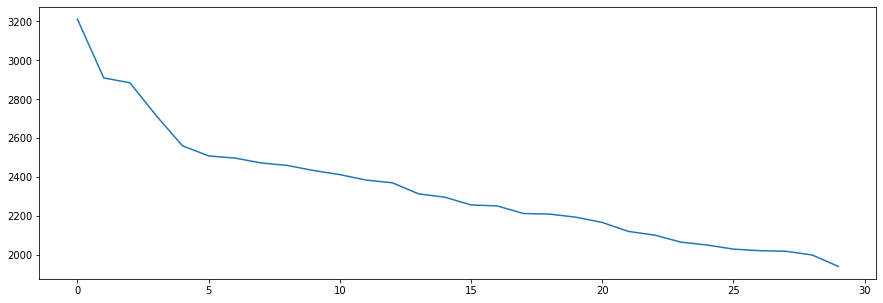

In [11]:

popular = ratings.groupby('movie_id')['user_id'].count()
# 내림차순 상위 30개
popular = popular.sort_values(ascending=False).head(30)
display(popular)
# popluar의 값들 그래프로 출력
plt.figure(figsize=(15,5))
plt.plot(popular.values)

In [12]:
ratings_movie = pd.merge(ratings, movies)
print(len(ratings), len(movies), len(ratings_movie))
ratings_movie

836478 3883 836478


,user_id,movie_id,counts,timestamp,title,genre
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,978199279,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,978158471,One Flew Over the Cuckoo's Nest (1975),Drama
...,...,...,...,...,...,...
836473,5851,3607,5,957756608,One Little Indian (1973),Comedy|Drama|Western
836474,5854,3026,4,958346883,Slaughterhouse (1987),Horror
836475,5854,690,3,957744257,"Promise, The (Versprechen, Das) (1994)",Romance
836476,5938,2909,4,957273353,"Five Wives, Three Secretaries and Me (1998)",Documentary


In [13]:
popular_name = ratings_movie.groupby('title')['movie_id'].count()
# 상위 30개를 출력
popular_name = popular_name.sort_values(ascending=False).head(30)
display(popular_name)

title
American Beauty (1999)                                   3211
Star Wars: Episode IV - A New Hope (1977)                2910
Star Wars: Episode V - The Empire Strikes Back (1980)    2885
Star Wars: Episode VI - Return of the Jedi (1983)        2716
Saving Private Ryan (1998)                               2561
Terminator 2: Judgment Day (1991)                        2509
Silence of the Lambs, The (1991)                         2498
Raiders of the Lost Ark (1981)                           2473
Back to the Future (1985)                                2460
Matrix, The (1999)                                       2434
Jurassic Park (1993)                                     2413
Sixth Sense, The (1999)                                  2385
Fargo (1996)                                             2371
Braveheart (1995)                                        2314
Men in Black (1997)                                      2297
Schindler's List (1993)                                  2257
Pr

# 3.선호영화 5개 추가하기

In [14]:
# id> movie name
def id_to_name(id):
    get = movies.index[movies.movie_id == id].tolist()
    return movies.title[get[0]]
# movie name > id
def name_to_id(title):
    get = movies.index[movies.title == title].tolist()
    return movies.movie_id[get[0]]

In [15]:
# ratings에 새로운 값을 넣어야하기 때문에 ratings에 어떤 열들이 있는지 확인
display(ratings.head())

,user_id,movie_id,counts,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


* movie_id 

영화 5개 추가
1. Silence of the Lambs, The (1991)    
2. Matrix, The (1999)  
3. Being John Malkovich (1999)
4. Forrest Gump (1994)  
5. Toy Story (1995) 

In [17]:
# display(movies[movies.title == 'Godfather, The (1972)'])
my_movies = ['Silence of the Lambs, The (1991)', 'Matrix, The (1999)', 'Being John Malkovich (1999)','Forrest Gump (1994)','Toy Story (1995)']

[name_to_id(i) for i in my_movies]

[593, 2571, 2997, 356, 1]

* user_id

In [18]:
ratings.tail()

,user_id,movie_id,counts,timestamp
1000203,6040,1090,3,956715518
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648
1000208,6040,1097,4,956715569


In [19]:
# 6045 user_id 확인 > 없음
ratings[ratings.user_id == 6045]

,user_id,movie_id,counts,timestamp


* timestamp

0          978300760
1          978302109
2          978301968
3          978300275
4          978824291
             ...    
1000203    956715518
1000205    956704887
1000206    956704746
1000207    956715648
1000208    956715569
Name: timestamp, Length: 836478, dtype: int64


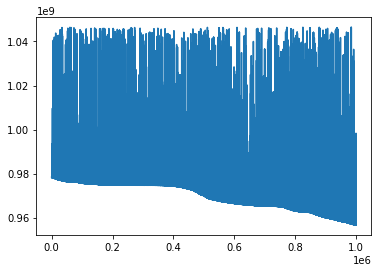

In [20]:
print(ratings.timestamp)
plt.plot(ratings.timestamp)

In [21]:
display(ratings.timestamp.duplicated())
ratings[ratings.timestamp == 956715569]

0          False
1          False
2          False
3          False
4          False
           ...  
1000203     True
1000205     True
1000206     True
1000207    False
1000208     True
Name: timestamp, Length: 836478, dtype: bool

,user_id,movie_id,counts,timestamp
999947,6040,1150,5,956715569
999954,6040,1185,5,956715569
999986,6040,3521,5,956715569
1000008,6040,1962,3,956715569
1000184,6040,2791,4,956715569
1000208,6040,1097,4,956715569


In [22]:
ratings[ratings.timestamp == 956000000]

,user_id,movie_id,counts,timestamp


* user_id : 6045
* movie_ide : [593, 2571, 2997, 356, 1]
* ratings : 4, 5, 4, 5, 5
* timestamp : 956000000

In [23]:

# 추가하기전 데이터프레임의 형태
display(ratings.tail(5))
# 추가할 내용 : movie_id
my_favorite = [593, 2571, 2997, 356, 1]
# 추가할 내용 : 평점(본 횟수)
my_counts = [5,5,5,4,4]
my_movielist = pd.DataFrame({'user_id': [6045]*5, 'movie_id' : my_favorite, 'counts' : my_counts, 'timestamp' : [956000000]*5})

# ratings 밑에 5줄을 추가. 추가한 데이터프레임은 ratings_edit으로 정의.
if not ratings.isin({'user_id':[6045]})['user_id'].any():
    ratings_edit = pd.concat([ratings, my_movielist]) 

# 추가된 데이터프레임의 형태
ratings_edit.tail(10)

,user_id,movie_id,counts,timestamp
1000203,6040,1090,3,956715518
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648
1000208,6040,1097,4,956715569


,user_id,movie_id,counts,timestamp
1000203,6040,1090,3,956715518
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648
1000208,6040,1097,4,956715569
0,6045,593,5,956000000
1,6045,2571,5,956000000
2,6045,2997,5,956000000
3,6045,356,4,956000000
4,6045,1,4,956000000


In [24]:
# Null 값 확인
ratings_edit.isnull().any()

user_id      False
movie_id     False
counts       False
timestamp    False
dtype: bool

# 4.CSR matrix 생성

In [25]:
num_user = ratings_edit['user_id'].nunique()
num_movie = ratings_edit['movie_id'].nunique()
user_unique = ratings_edit['user_id'].unique()
movie_unique = ratings_edit['movie_id'].unique()
print(num_user, num_movie)
print(user_unique, movie_unique)

6040 3628
[   1    2    3 ... 6039 6040 6045] [1193  661  914 ...  690 2909 1360]


In [26]:
from scipy.sparse import csr_matrix

In [27]:
max_user = ratings_edit.user_id.max()
max_movie = ratings_edit.movie_id.max()
print(max_user)
print(max_movie)

csr_data = csr_matrix((ratings_edit.counts, (ratings_edit.user_id, ratings_edit.movie_id)), shape= (max_user+1, max_movie+1))
csr_data

6045
3952


<6046x3953 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Row format>

#5.als_model 모델 구성, 훈련

In [28]:
from implicit.als import AlternatingLeastSquares
import os
import numpy as np

os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

In [29]:
als_model = AlternatingLeastSquares(factors=100, regularization=0.01, use_gpu=False, iterations=15, dtype=np.float32)

In [30]:
als_model.fit(csr_data)

  0%|          | 0/15 [00:00<?, ?it/s]

In [31]:
als_model

#6.나의 선호도

In [32]:
display(movies[movies.title == 'Toy Story (1995)'])
display(movies[movies.title == 'Now and Then (1995)'])

print(name_to_id('Toy Story (1995)'))
print(name_to_id('Now and Then (1995)'))

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy


,movie_id,title,genre
26,27,Now and Then (1995),Drama


1
27


In [33]:
# print(id_to_title(1))
# print(id_to_title(27))

In [34]:
my_vector_1, movie_vector_1 = als_model.user_factors[6045], als_model.item_factors[1]
my_vector_2, movie_vector_2 = als_model.user_factors[6045], als_model.item_factors[27]

In [35]:
# 내적값
print(np.dot(my_vector_1, movie_vector_1))
print(np.dot(my_vector_2, movie_vector_2))

0.5143782
0.0028443122


#7.비슷한 영화 추천받기

In [37]:
# toy story
my_favorite_movie = 1

similar_movies, similar_moives_percent = als_model.similar_items(my_favorite_movie, N=15)

# print(similar_movies)
# print(similar_moives_percent)
similar_movie = [(similar_movies[i], similar_moives_percent[i]) for i in range(15)]
[id_to_name(i) for i, _ in similar_movie]

['Toy Story (1995)',
 'Toy Story 2 (1999)',
 "Bug's Life, A (1998)",
 'Babe (1995)',
 'Aladdin (1992)',
 'Groundhog Day (1993)',
 'Beauty and the Beast (1991)',
 'Lion King, The (1994)',
 "There's Something About Mary (1998)",
 'Pleasantville (1998)',
 'Mulan (1998)',
 'Tarzan (1999)',
 'Shakespeare in Love (1998)',
 'Hercules (1997)',
 'Forrest Gump (1994)']

#8. 내가 좋아할 영화 추천받기

In [38]:
user_id = 6045
movie_recommended, movie_recommended_percent = als_model.recommend(user_id, csr_data[user_id], N=15, filter_already_liked_items=True)
movie_rc = [(movie_recommended[i], movie_recommended_percent[i]) for i in range(15)]
movie_rc

[(2762, 0.56900936),
 (2858, 0.5659573),
 (3114, 0.42834544),
 (2028, 0.4205594),
 (1265, 0.4194669),
 (1210, 0.35144687),
 (2396, 0.3447681),
 (318, 0.33621666),
 (589, 0.33345342),
 (527, 0.33228815),
 (608, 0.3181004),
 (457, 0.3016545),
 (34, 0.29800838),
 (1270, 0.29309532),
 (1617, 0.28619784)]

In [39]:
#영화 이름으로 보기
[id_to_name(i) for i, _ in movie_rc]

['Sixth Sense, The (1999)',
 'American Beauty (1999)',
 'Toy Story 2 (1999)',
 'Saving Private Ryan (1998)',
 'Groundhog Day (1993)',
 'Star Wars: Episode VI - Return of the Jedi (1983)',
 'Shakespeare in Love (1998)',
 'Shawshank Redemption, The (1994)',
 'Terminator 2: Judgment Day (1991)',
 "Schindler's List (1993)",
 'Fargo (1996)',
 'Fugitive, The (1993)',
 'Babe (1995)',
 'Back to the Future (1985)',
 'L.A. Confidential (1997)']

In [40]:
explain = als_model.explain(user_id, csr_data, itemid=1221)
[(id_to_name(i), j) for i, j in explain[1]]

[('Silence of the Lambs, The (1991)', 0.01227787167601228),
 ('Matrix, The (1999)', 0.005874260843551378),
 ('Forrest Gump (1994)', -0.0025339573174886195),
 ('Being John Malkovich (1999)', -0.0033092747612947135),
 ('Toy Story (1995)', -0.008677622355972211)]

* 'Silence of the Lambs, The (1991)
* 'Matrix, The (1999)'

가 추천영화에 높은 기여를 보임

# 회고

### - 이번 프로젝트에서 **어려웠던 점**.
* implicit import 오류가 났다.

### - 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
추천 시스템에서 자주 사용되는 데이터 구조인 CSR Matrix을 이해하게 되었다.

### - 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.


>#### **루브릭평가 지표**
>|번호|평가문항|상세기준|
>|:---:|---|---|
>|1| CSR matrix가 정상적으로 만들어졌다. |사용자와 아이템 개수를 바탕으로 정확한 사이즈로 만들었다.|
>|2| MF 모델이 정상적으로 훈련되어 그럴듯한 추천이 이루어졌다.| 사용자와 아이템 벡터 내적수치가 의미있게 형성되었다.|
>|3|비슷한 영화 찾기와 유저에게 추천하기의 과정이 정상적으로 진행되었다.|MF모델이 예측한 유저 선호도 및 아이템간 유사도, 기여도를 측정하고 의미를 분석해보았다.|



### - **자기 다짐**
* 코드 복기